In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

plt.rcParams["figure.figsize"] = (10, 6)


C:\Users\John DeForest\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = r"C:\Users\John DeForest\Downloads\longform_conv1.csv"

df = pd.read_csv(path)

print(df.head())
print(df.columns.tolist())
print(df.shape)


   Age     Name                                           Response
0   58   Buxton  Longform Notes\nHas fished for urchin and lobs...
1   73  Kennedy  Mentions SD Warren → a papermill in Westbrook....
2   40   Gilley  Harpswell has 5% of the entire Maine lobster f...
3   42  Koerber  In the summer, fishes inshore; in the fall and...
4   40    Spear  Mentions a lot of eutrophication present in Ca...
['Age', 'Name', 'Response']
(20, 3)


In [11]:
TEXT_COL = "Response"

# Drop missing responses and ensure string
df_text = df.dropna(subset=[TEXT_COL]).copy()
df_text[TEXT_COL] = df_text[TEXT_COL].astype(str).str.strip()

print("Rows with non-missing Response:", df_text.shape[0])

documents = df_text[TEXT_COL].tolist()
print("Number of documents:", len(documents))
print("Example doc snippet:", documents[0][:300])


Rows with non-missing Response: 18
Number of documents: 18
Example doc snippet: Longform Notes
Has fished for urchin and lobstered as his career (also commercial diver).
Is a Zone 2 urchin diver = Vinalhaven region to the Canadian border. 
Mentions how the zoning for Maine’s coast that was consistent in 1996/1997 was installed over a map NOT over traditional boundaries that wou


In [12]:
# Vectorizer
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    stop_words="english",
    min_df=1
)

# UMAP
umap_model = UMAP(
    n_neighbors=10,
    n_components=2,
    metric="cosine",
    random_state=42
)

# HDBSCAN
hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean",
    prediction_data=True
)

# Representation model
rep_model = KeyBERTInspired()

# BERTopic model
topic_model = BERTopic(
    embedding_model="all-mpnet-base-v2",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    representation_model=rep_model,
    verbose=True,
)

topics, probs = topic_model.fit_transform(documents)


2025-11-17 16:11:06,501 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]
2025-11-17 16:11:13,215 - BERTopic - Embedding - Completed ✓
2025-11-17 16:11:13,216 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 16:11:13,246 - BERTopic - Dimensionality - Completed ✓
2025-11-17 16:11:13,247 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 16:11:13,252 - BERTopic - Cluster - Completed ✓
2025-11-17 16:11:13,255 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 16:11:14,808 - BERTopic - Representation - Completed ✓


In [13]:
save_dir = r"C:\Users\John DeForest\Downloads\tmres_longform1"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "topic_model_longform1")
topic_model.save(model_path)
print("Model saved to:", model_path)

topic_info = topic_model.get_topic_info()
print(topic_info)
print("Number of topics (excluding -1):", (topic_info.Topic != -1).sum())


2025-11-17 16:11:14,860 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Model saved to: C:\Users\John DeForest\Downloads\tmres_longform1\topic_model_longform1
   Topic  Count                                               Name  \
0     -1      2  -1_lobster industry_lobstering community_fishe...   
1      0     10     0_lobster industry_fishery_lobsters_lobstering   
2      1      3  1_influenced lobstermen_fisheries_fishery_lobs...   
3      2      3  2_offshore lobstering_fishermen_lobster fishin...   

                                      Representation  \
0  [lobster industry, lobstering community, fishe...   
1  [lobster industry, fishery, lobsters, lobsteri...   
2  [influenced lobstermen, fisheries, fishery, lo...   
3  [offshore lobstering, fishermen, lobster fishi...   

                                 Representative_Docs  
0  [Mentions concern about mercury as more dams a...  
1  [Notes Quahog Bay Conservancy is testing micro...  
2  [In the summer, fishes inshore; in the fall an...  
3  [Mentions a lot of eutrophication present in C...  
Number

In [14]:
df_text = df_text.reset_index(drop=True)

df_topics_docs = df_text.copy()
df_topics_docs["Topic"] = topics

# Quick look at a few responses per topic
for t in sorted(set(topics)):
    if t == -1:
        continue
    print("\n=== Topic", t, "===")
    print("Top words:", topic_model.get_topic(t))
    print(df_topics_docs.loc[df_topics_docs["Topic"] == t, TEXT_COL].head(3))



=== Topic 0 ===
Top words: [('lobster industry', np.float32(0.65851563)), ('fishery', np.float32(0.51950854)), ('lobsters', np.float32(0.50512826)), ('lobstering', np.float32(0.489765)), ('lobstermen', np.float32(0.48191112)), ('lobster', np.float32(0.46231005)), ('fishing', np.float32(0.4403064)), ('fishermen', np.float32(0.39502084)), ('crabs', np.float32(0.38089985)), ('maine', np.float32(0.38001084))]
1    Mentions SD Warren → a papermill in Westbrook....
2    Harpswell has 5% of the entire Maine lobster f...
6    Used to fish offshore, but now many guys fish ...
Name: Response, dtype: object

=== Topic 1 ===
Top words: [('influenced lobstermen', np.float32(0.5284424)), ('fisheries', np.float32(0.50240564)), ('fishery', np.float32(0.4762026)), ('lobstermen role', np.float32(0.46829456)), ('lobstering territory', np.float32(0.44956988)), ('maine lobster', np.float32(0.4431529)), ('lobstermen', np.float32(0.44173878)), ('lobstering', np.float32(0.42872253)), ('lobsters', np.float32(

In [15]:
combined_path = os.path.join(save_dir, "longform_with_topics.csv")
df_topics_docs.to_csv(combined_path, index=False)
print("Saved responses + topics to:", combined_path)


Saved responses + topics to: C:\Users\John DeForest\Downloads\tmres_longform1\longform_with_topics.csv


In [16]:
topic_info = topic_model.get_topic_info()
valid_topic_ids = topic_info[topic_info.Topic != -1].Topic.tolist()

topics_data = []
for topic_id in valid_topic_ids:
    topic = topic_model.get_topic(topic_id)
    if topic is None:
        continue
    for word, weight in topic:
        topics_data.append((topic_id, word, weight))

topics_df = pd.DataFrame(topics_data, columns=["Topic", "Word", "Weight"])
print(topics_df.head())
print("Number of rows in topics_df:", len(topics_df))

csv_path = os.path.join(save_dir, "topic_keywords_longform1.csv")
topics_df.to_csv(csv_path, index=False)
print("Topic keyword CSV saved to:", csv_path)


   Topic              Word    Weight
0      0  lobster industry  0.658516
1      0           fishery  0.519509
2      0          lobsters  0.505128
3      0        lobstering  0.489765
4      0        lobstermen  0.481911
Number of rows in topics_df: 30
Topic keyword CSV saved to: C:\Users\John DeForest\Downloads\tmres_longform1\topic_keywords_longform1.csv


In [17]:
topic_model.visualize_topics()


C:\Users\John DeForest\AppData\Roaming\Python\Python313\site-packages\umap\spectral.py:519: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(


TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [18]:
hierarchical_topics = topic_model.hierarchical_topics(documents)
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

topic_model.visualize_hierarchy()


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


.
├─■──influenced lobstermen_fisheries_fishery_lobstermen role_lobstering territory ── Topic: 1
└─lobster industry_fishery_lobstermen_lobstering_lobsters
     ├─■──lobster industry_fishery_lobsters_lobstering_lobstermen ── Topic: 0
     └─■──offshore lobstering_fishermen_lobster fishing_lobstermen_lobstermens ── Topic: 2



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAADt6v4k4DnlP+3q/iTgOeU/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAALsAAAAAAAAAuwAAAAAAAADnAAAAAAAAAOcA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAABkdFgxT13oP2R0WDFPXeg/7er+JOA55T8=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAAFMAAAAAAAAAUwAAAAAAAADTAAAAAAAAANMA=', 'dtype': 'f8'},
              'yaxis': 'y'}],
    'layout': {'autosize': False,
               'height': 245,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'hovermode': 'closest',
               'plot_bgcolor': '#ECEFF1',
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Hierarchical Clustering</b>',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
               'width': 1000,
               'xaxis': {'mirror': 'allticks',
                         'rangemode': 'tozero',
                         'showgrid': False,
                         'showline': True,
                         'showticklabels': True,
                         'ticks': 'outside',
                         'type': 'linear',
                         'zeroline': False},
               'yaxis': {'mirror': 'allticks',
                         'range': [-30.0, 0.0],
                         'rangemode': 'tozero',
                         'showgrid': False,
                         'showline': True,
                         'showticklabels': True,
                         'tickmode': 'array',
                         'ticks': 'outside',
                         'ticktext': [1_influenced lobstermen_fis..., 0_lobster
                                      industry_fishery_..., 2_offshore
                                      lobstering_fishe...],
                         'tickvals': [-5.0, -15.0, -25.0],
                         'type': 'linear',
                         'zeroline': False}}
})

In [19]:
import numpy as np

df_text["Age"] = pd.to_numeric(df_text["Age"], errors="coerce")
df_age = df_text.dropna(subset=["Age"]).reset_index(drop=True)

documents_age = df_age[TEXT_COL].astype(str).tolist()
ages = df_age["Age"].astype(float).tolist()

print("Docs with Age:", len(documents_age))
print("Example ages:", ages[:10])

updated_topics, _ = topic_model.transform(documents_age)

topics_over_time = topic_model.topics_over_time(
    documents_age,
    ages,
    updated_topics
)

fig = topic_model.visualize_topics_over_time(
    topics_over_time,
    title="Longform Topics Across Age"
)
fig


Docs with Age: 18
Example ages: [58.0, 73.0, 40.0, 42.0, 40.0, 47.0, 58.0, 28.0, 68.0, 56.0]


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]
2025-11-17 16:11:30,834 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-11-17 16:11:30,835 - BERTopic - Dimensionality - Completed ✓
2025-11-17 16:11:30,836 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-11-17 16:11:30,838 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-11-17 16:11:30,843 - BERTopic - Probabilities - Completed ✓
2025-11-17 16:11:30,845 - BERTopic - Cluster - Completed ✓
13it [00:17,  1.38s/it]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'hovertext': [<b>Topic 0</b><br>Words: lobster industry, fisheries,
                            lobstermen, lobsters, lobster, <b>Topic 0</b><br>Words:
                            fishermen trusted, frustration fishermen, know
                            fishermen, fishermen, interviewees state, <b>Topic
                            0</b><br>Words: lobster industry, cundy harbor,
                            fishery, lobstering, lobsters, <b>Topic 0</b><br>Words:
                            interviewees, interviews, fishery, lobstering,
                            lobstermen, <b>Topic 0</b><br>Words: concern pollution,
                            states concerns, undervalued fishermen, concerns
                            windfarms, state waters, <b>Topic 0</b><br>Words:
                            damage lobsters, stage lobsters, lobsters, lobstermen,
                            lobster, <b>Topic 0</b><br>Words: lobster industry,
                            lobster fishery, fishery, pollution, lobstermen,
                            <b>Topic 0</b><br>Words: fishery, waterfront,
                            pollution, casco bay, feeding sewage],
              'marker': {'color': '#E69F00'},
              'mode': 'lines',
              'name': '0_lobster industry_fishery_lobsters_lobs...',
              'type': 'scatter',
              'x': {'bdata': ('AAAAAAAAOEAAAAAAAIBAQAAAAAAAAE' ... 'AAAE1AAAAAAAAAUUAAAAAAAEBSQA=='),
                    'dtype': 'f8'},
              'y': {'bdata': 'AgEBAQEBAQI=', 'dtype': 'i1'}},
             {'hoverinfo': 'text',
              'hovertext': [<b>Topic 1</b><br>Words: winter fishing, affect
                            lobster, fishery, lobstering territory, lobstering,
                            <b>Topic 1</b><br>Words: maine fisheries, insights
                            fishermen, fisheries interesting, fisheries fishermen,
                            fishes offshore, <b>Topic 1</b><br>Words: lobster
                            fishery, fishery curious, maine lobster, influenced
                            lobstermen, lobstermen role],
              'marker': {'color': '#56B4E9'},
              'mode': 'lines',
              'name': '1_influenced lobstermen_fisheries_fisher...',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAO0AAAAAAAABFQAAAAAAAAE1A', 'dtype': 'f8'},
              'y': {'bdata': 'AQEB', 'dtype': 'i1'}},
             {'hoverinfo': 'text',
              'hovertext': [<b>Topic 2</b><br>Words: offshore lobstering, lobster
                            industry, understand fishery, lobster fishing,
                            lobstering, <b>Topic 2</b><br>Words: notched lobsters,
                            lobster coast, old lobsters, lobsters, recommendation
                            lobster, <b>Topic 2</b><br>Words: lobstermen concerned,
                            issues lobstermen, lobster fishing, lobsterman
                            association, lobstering],
              'marker': {'color': '#009E73'},
              'mode': 'lines',
              'name': '2_offshore lobstering_fishermen_lobster ...',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAPEAAAAAAAABEQAAAAAAAAE5A', 'dtype': 'f8'},
              'y': {'bdata': 'AQEB', 'dtype': 'i1'}}],
    'layout': {'height': 450,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'title': {'text': '<b>Global Topic Representation'}},
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': 'Longform Topics Across Age',
                         'x': 0.4,
                         'xanchor': 'center',
                         'y': 0.95,
                         'yanchor': 'top'},
               'width': 1250,
               'xaxis': {'showgrid': True},
               'yaxis': {'showgr

In [20]:
topic_info = topic_model.get_topic_info()
print(topic_info)
print("Non-outlier topics:", (topic_info.Topic != -1).sum())


   Topic  Count                                               Name  \
0     -1      2  -1_lobster industry_lobstering community_fishe...   
1      0     10     0_lobster industry_fishery_lobsters_lobstering   
2      1      3  1_influenced lobstermen_fisheries_fishery_lobs...   
3      2      3  2_offshore lobstering_fishermen_lobster fishin...   

                                      Representation  \
0  [lobster industry, lobstering community, fishe...   
1  [lobster industry, fishery, lobsters, lobsteri...   
2  [influenced lobstermen, fisheries, fishery, lo...   
3  [offshore lobstering, fishermen, lobster fishi...   

                                 Representative_Docs  
0  [Mentions concern about mercury as more dams a...  
1  [Notes Quahog Bay Conservancy is testing micro...  
2  [In the summer, fishes inshore; in the fall an...  
3  [Mentions a lot of eutrophication present in C...  
Non-outlier topics: 3


In [21]:
fig = topic_model.visualize_barchart(
    top_n_topics=None,   # show all topics
    n_words=10,          # top words per topic
    title="Longform Topics"
)
fig


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.38001084327697754, 0.3808998465538025, 0.39502084255218506,
                    0.4403063952922821, 0.4623100459575653, 0.4819111227989197,
                    0.4897649884223938, 0.5051282644271851, 0.5195085406303406,
                    0.6585156321525574],
              'xaxis': 'x',
              'y': [maine  , crabs  , fishermen  , fishing  , lobster  ,
                    lobstermen  , lobstering  , lobsters  , fishery  , lobster
                    industry  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.4134209454059601, 0.41477450728416443, 0.4287225306034088,
                    0.4417387843132019, 0.44315290451049805, 0.4495698809623718,
                    0.46829456090927124, 0.4762026071548462, 0.5024056434631348,
                    0.5284423828125],
              'xaxis': 'x2',
              'y': [conservation efforts  , lobsters  , lobstering  , lobstermen
                    , maine lobster  , lobstering territory  , lobstermen role  ,
                    fishery  , fisheries  , influenced lobstermen  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.36551427841186523, 0.3733561635017395, 0.3783775568008423,
                    0.3801811933517456, 0.38133156299591064, 0.38321274518966675,
                    0.39711105823516846, 0.4109722971916199, 0.41104796528816223,
                    0.46922582387924194],
              'xaxis': 'x3',
              'y': [notched lobsters  , lobster coast  , ecosystem  , fishing  ,
                    old lobsters  , lobstermens  , lobstermen  , lobster fishing  ,
                    fishermen  , offshore lobstering  ],
              'yaxis': 'y3'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 2',
                                'x': 0.6375000000000001,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 325.0,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': 'Longform Topics',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.175], 'showgrid': True},
               'xaxis2': {'anchor': 'y2', 'domain': [0.275, 0.45], 'show

In [22]:
fig = topic_model.visualize_heatmap(
    top_n_topics=None,
    n_clusters=None,
    title="Topic Similarity (Heatmap)"
)
fig


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_lobster industry_fishery_..., 1_influenced
                    lobstermen_fis..., 2_offshore lobstering_fishe...],
              'xaxis': 'x',
              'y': [0_lobster industry_fishery_..., 1_influenced
                    lobstermen_fis..., 2_offshore lobstering_fishe...],
              'yaxis': 'y',
              'z': {'bdata': 'AgCAP7ffXD99P1g/t99cPwEAgD+BJF0/fT9YP4EkXT/4/38/', 'dtype': 'f4', 'shape': '3, 3'}}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Similarity Score'}},
                             'colorscale': [[0.0, 'rgb(247,252,240)'], [0.125,
                                            'rgb(224,243,219)'], [0.25,
                                            'rgb(204,235,197)'], [0.375,
                                            'rgb(168,221,181)'], [0.5,
                                            'rgb(123,204,196)'], [0.625,
                                            'rgb(78,179,211)'], [0.75,
                                            'rgb(43,140,190)'], [0.875,
                                            'rgb(8,104,172)'], [1.0,
                                            'rgb(8,64,129)']]},
               'height': 800,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'title': {'text': 'Trend'}},
               'margin': {'t': 60},
               'showlegend': True,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': 'Topic Similarity (Heatmap)',
                         'x': 0.55,
                         'xanchor': 'center',
                         'y': 0.95,
                         'yanchor': 'top'},
               'width': 800,
               'xaxis': {'anchor': 'y', 'constrain': 'domain', 'domain': [0.0, 1.0], 'scaleanchor': 'y'},
               'yaxis': {'anchor': 'x', 'autorange': 'reversed', 'constrain': 'domain', 'domain': [0.0, 1.0]}}
})

In [23]:
#NOW REMOVE THE WORD LOBSTER ETC
import re

# New column with lobster-related words removed (case-insensitive)
df["ResponseNoLobster"] = (
    df["Response"]
    .fillna("")
    .str.replace(r"\b(lobster|lobsters|lobstermen|lobstering)\b", "",
                 flags=re.IGNORECASE, regex=True)
    .str.replace(r"\s{2,}", " ", regex=True)  # collapse double spaces
    .str.strip()
)

df[["Response", "ResponseNoLobster"]].head()



,Response,ResponseNoLobster
0,Longform Notes\nHas fished for urchin and lobs...,Longform Notes\nHas fished for urchin and lobs...
1,Mentions SD Warren → a papermill in Westbrook....,Mentions SD Warren → a papermill in Westbrook....
2,Harpswell has 5% of the entire Maine lobster f...,"Harpswell has 5% of the entire Maine fleet, an..."
3,"In the summer, fishes inshore; in the fall and...","In the summer, fishes inshore; in the fall and..."
4,Mentions a lot of eutrophication present in Ca...,Mentions a lot of eutrophication present in Ca...


In [24]:
TEXT_COL = "ResponseNoLobster"

df_text = df.dropna(subset=[TEXT_COL]).copy()
df_text[TEXT_COL] = df_text[TEXT_COL].astype(str).str.strip()

print("Rows with non-missing ResponseNoLobster:", df_text.shape[0])

documents = df_text[TEXT_COL].tolist()
print("Number of documents:", len(documents))
print("Example doc snippet:", documents[0][:300])


Rows with non-missing ResponseNoLobster: 20
Number of documents: 20
Example doc snippet: Longform Notes
Has fished for urchin and lobstered as his career (also commercial diver).
Is a Zone 2 urchin diver = Vinalhaven region to the Canadian border. Mentions how the zoning for Maine’s coast that was consistent in 1996/1997 was installed over a map NOT over traditional boundaries that woul


In [25]:
# assumes vectorizer_model, umap_model, hdbscan_model, KeyBERTInspired already imported/defined
rep_model = KeyBERTInspired()

topic_model = BERTopic(
    embedding_model="all-mpnet-base-v2",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    representation_model=rep_model,
    verbose=True,
)

topics, probs = topic_model.fit_transform(documents)


2025-11-17 16:11:49,395 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]
2025-11-17 16:11:57,662 - BERTopic - Embedding - Completed ✓
2025-11-17 16:11:57,663 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-17 16:11:57,712 - BERTopic - Dimensionality - Completed ✓
2025-11-17 16:11:57,714 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-17 16:11:57,722 - BERTopic - Cluster - Completed ✓
2025-11-17 16:11:57,726 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-17 16:11:59,668 - BERTopic - Representation - Completed ✓


In [26]:
fig = topic_model.visualize_barchart(
    top_n_topics=None,
    n_words=10,
    title="Longform Topics (Lobster words removed)"
)
fig


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.4099504053592682, 0.4100126028060913, 0.41105788946151733,
                    0.4242748022079468, 0.4356116056442261, 0.45534226298332214,
                    0.47701936960220337, 0.5084726214408875, 0.5757507681846619,
                    0.5984908938407898],
              'xaxis': 'x',
              'y': [coastal  , cundy harbor  , maine  , harbor  , shellfish  ,
                    fish  , fishermen  , fishing  , fishery  , fisheries  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.31601572036743164, 0.31804391741752625, 0.33578380942344666,
                    0.344113826751709, 0.36572062969207764, 0.38130277395248413,
                    0.39194291830062866, 0.422564297914505, 0.48140570521354675,
                    0.5233309268951416],
              'xaxis': 'x2',
              'y': [bay  , fish  , fishes  , coastal  , ecosystem  , fishing  ,
                    fishermen  , pollution  , fishery  , fisheries  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.3212392032146454, 0.3263545334339142, 0.32860133051872253,
                    0.32966989278793335, 0.3299867510795593, 0.33167073130607605,
                    0.37475278973579407, 0.4190083146095276, 0.44386279582977295,
                    0.4461536109447479],
              'xaxis': 'x3',
              'y': [trash dumping  , sustainable respectful  , community  ,
                    sustainable  , bay  , maine  , fisherman  , community
                    sustainable  , coast fisherman  , pollution  ],
              'yaxis': 'y3'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 2',
                                'x': 0.6375000000000001,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 325.0,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': 'Longform Topics (Lobster words removed)',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.175], 'showgrid': True},
               'xaxis2': {'anchor': 'y2', 'domain': [0.275, 0.45], 'showgrid': True},
               'xaxis3': {'anchor': 'y3', 'domain': [0.55, 0.72500000000

Non-outlier topics: 3


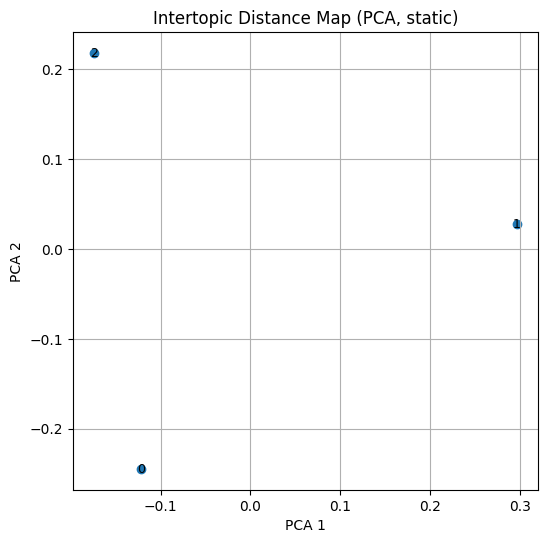

In [32]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

topic_info = topic_model.get_topic_info()
valid_topic_ids = topic_info[topic_info.Topic != -1].Topic.tolist()
n_topics = len(valid_topic_ids)

print("Non-outlier topics:", n_topics)

if n_topics < 2:
    print("Need at least 2 topics for an intertopic distance map.")
else:
    # Get embeddings for valid topics
    emb = topic_model.topic_embeddings_[valid_topic_ids]

    # 2D PCA projection
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(emb)

    # Labels
    topic_info_idx = topic_info.set_index("Topic")
    labels = topic_info_idx.loc[valid_topic_ids, "Name"].tolist()

    # Matplotlib scatter
    plt.figure(figsize=(6, 6))
    plt.scatter(coords[:, 0], coords[:, 1])

    for (x, y, tid, label) in zip(coords[:, 0], coords[:, 1], valid_topic_ids, labels):
        plt.text(x, y, f"{tid}", fontsize=9, ha="center", va="center")

    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("Intertopic Distance Map (PCA, static)")
    plt.gca().set_aspect("equal", "box")
    plt.grid(True)
    plt.show()


In [33]:
#NOW SENTIMENT ANALYSIS VADER SENTIMENT

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon once
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to C:\Users\John
[nltk_data]     DeForest\AppData\Roaming\nltk_data...


In [34]:
# Use the same text column you used for BERTopic
# TEXT_COL = "ResponseNoLobster"  # or "Response"
print("Using text column:", TEXT_COL)

# Ensure Age is numeric
df_text["Age"] = pd.to_numeric(df_text["Age"], errors="coerce")

# Drop rows with missing Age
df_sent = df_text.dropna(subset=["Age", TEXT_COL]).copy()

# Compute VADER 'compound' score (-1 = very negative, +1 = very positive)
df_sent["sentiment"] = df_sent[TEXT_COL].apply(
    lambda x: sia.polarity_scores(str(x))["compound"]
)

df_sent[["Age", TEXT_COL, "sentiment"]].head()


Using text column: ResponseNoLobster


,Age,ResponseNoLobster,sentiment
0,58,Longform Notes\nHas fished for urchin and lobs...,0.9435
1,73,Mentions SD Warren → a papermill in Westbrook....,-0.5044
2,40,"Harpswell has 5% of the entire Maine fleet, an...",0.9246
3,42,"In the summer, fishes inshore; in the fall and...",-0.3182
4,40,Mentions a lot of eutrophication present in Ca...,0.2664


In [35]:
print("Sentiment summary:")
print(df_sent["sentiment"].describe())

corr = df_sent[["Age", "sentiment"]].corr().loc["Age", "sentiment"]
print(f"\nCorrelation between Age and sentiment: {corr:.3f}")


Sentiment summary:
count    20.000000
mean      0.335225
std       0.685148
min      -0.973400
25%      -0.200075
50%       0.691400
75%       0.940050
max       0.993700
Name: sentiment, dtype: float64

Correlation between Age and sentiment: 0.011


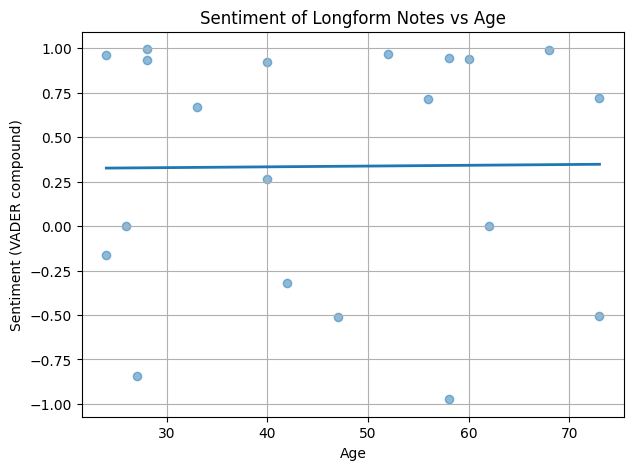

In [36]:
import numpy as np
import matplotlib.pyplot as plt

x = df_sent["Age"].values
y = df_sent["sentiment"].values

# Fit simple linear regression (Age → sentiment)
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.5)
plt.plot(np.sort(x), m * np.sort(x) + b, linewidth=2)

plt.xlabel("Age")
plt.ylabel("Sentiment (VADER compound)")
plt.title("Sentiment of Longform Notes vs Age")
plt.grid(True)
plt.show()


  AgeGroup  sentiment
0      <30   0.313417
1    30–39   0.666700
2    40–49   0.090475
3    50–59   0.412950
4    60–69   0.643567
5    70–79   0.106450
6      80+        NaN


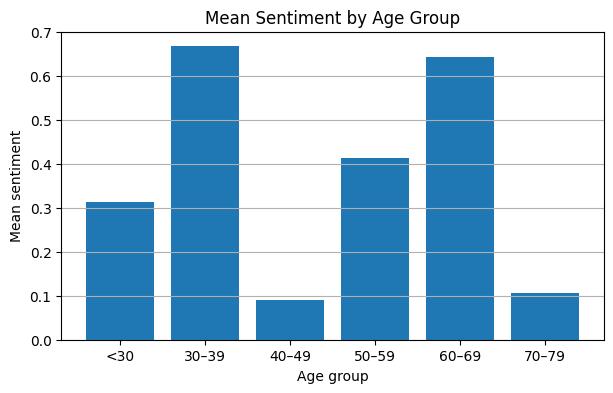

In [37]:
# Define age bins (tweak as needed)
bins = [0, 29, 39, 49, 59, 69, 79, 120]
labels = ["<30", "30–39", "40–49", "50–59", "60–69", "70–79", "80+"]

df_sent["AgeGroup"] = pd.cut(df_sent["Age"], bins=bins, labels=labels, right=True)

sent_by_group = df_sent.groupby("AgeGroup")["sentiment"].mean().reset_index()
print(sent_by_group)

plt.figure(figsize=(7, 4))
plt.bar(sent_by_group["AgeGroup"].astype(str), sent_by_group["sentiment"])
plt.xlabel("Age group")
plt.ylabel("Mean sentiment")
plt.title("Mean Sentiment by Age Group")
plt.grid(axis="y")
plt.show()


In [39]:
#now sentiment vs TOPICS
TEXT_COL = "ResponseNoLobster"

# Rebuild df_text from the full df
df_text = df.dropna(subset=[TEXT_COL]).copy()
df_text[TEXT_COL] = df_text[TEXT_COL].astype(str).str.strip()
df_text = df_text.reset_index(drop=True)

# Rebuild df_topics_docs so it includes ResponseNoLobster + Topic
df_topics_docs = df_text.copy()
df_topics_docs["Topic"] = topics

print(df_topics_docs.columns)
df_topics_docs.head()

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download once (no-op if already done)
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

# Compute VADER compound score for each response
df_topics_docs["sentiment"] = df_topics_docs[TEXT_COL].astype(str).apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

df_topics_docs[["Topic", TEXT_COL, "sentiment"]].head()


Index(['Age', 'Name', 'Response', 'ResponseNoLobster', 'Topic'], dtype='object')


[nltk_data] Downloading package vader_lexicon to C:\Users\John
[nltk_data]     DeForest\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Topic,ResponseNoLobster,sentiment
0,1,Longform Notes\nHas fished for urchin and lobs...,0.9435
1,1,Mentions SD Warren → a papermill in Westbrook....,-0.5044
2,0,"Harpswell has 5% of the entire Maine fleet, an...",0.9246
3,1,"In the summer, fishes inshore; in the fall and...",-0.3182
4,1,Mentions a lot of eutrophication present in Ca...,0.2664


In [40]:
valid = df_topics_docs[df_topics_docs["Topic"] != -1].copy()

topic_sent_summary = (
    valid.groupby("Topic")["sentiment"]
         .agg(["count", "mean", "std", "median", "min", "max"])
         .reset_index()
)
print(topic_sent_summary)


   Topic  count      mean       std  median     min     max
0      0      9  0.525967  0.737823  0.9246 -0.9734  0.9937
1      1      6  0.079217  0.756607 -0.0259 -0.8446  0.9435
2      2      3 -0.053567  0.092780  0.0000 -0.1607  0.0000


<Figure size 800x500 with 0 Axes>

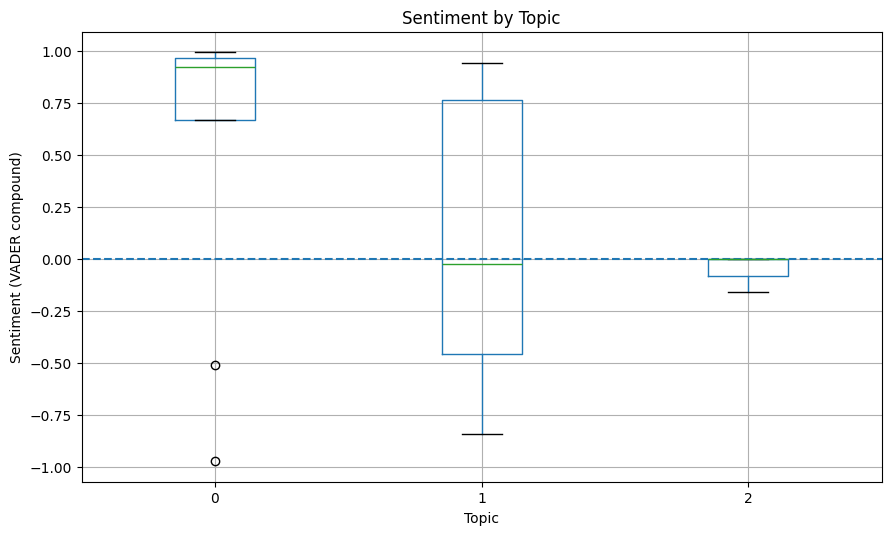

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
valid.boxplot(column="sentiment", by="Topic")
plt.axhline(0, linestyle="--")  # neutral reference line
plt.title("Sentiment by Topic")
plt.suptitle("")  # remove default super-title
plt.xlabel("Topic")
plt.ylabel("Sentiment (VADER compound)")
plt.show()


In [42]:
import scipy.stats as stats

groups = [
    g["sentiment"].values
    for tid, g in valid.groupby("Topic")
]

H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")


Kruskal–Wallis H = 2.439, p = 0.2954
